# Analysis of long-read transcriptomes

By Fairlie Reese

Please email me if you have any problems or questions! freese@uci.edu

## Data download and formatting

### Long-read data

Note: 
* Astrocyte data currently not publically available. This page will be updated when it is!
* These files already contain full-length non-chimeric reads. They have been processed as per the pipeline outlined [here](https://www.encodeproject.org/documents/7ec9d66a-3b7e-4183-8677-e1df14770b44/@@download/attachment/ENCODE%20Long%20Read%20RNA-Seq%20Analysis%20Pipeline%20%28Human%29.pdf)

```bash
# download files
wget http://crick.bio.uci.edu/freese/210413_pgp1_hub/encode_files_dl.txt .
xargs -L 1 curl -O -J -L < files.txt

# unzip
gunzip *fastq.gz

# rename them to make sense
mv ENCFF954UFG.fastq > pgp1_1.fastq
mv ENCFF251CBB.fastq > pgp1_2.fastq
mv ENCFF919JFJ.fastq > excite_neuron_1.fastq
mv ENCFF982WKN.fastq > excite_neuron_2.fastq
# mv ____.fastq > astro_1.fastq
# mv ____.fastq > astro_2.fastq
```

### Reference data
```bash 
# human reference genome 
wget https://www.encodeproject.org/files/GRCh38_no_alt_analysis_set_GCA_000001405.15/@@download/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz
gunzip GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz
mv GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta hg38.fasta

# human reference genome chrom sizes
wget https://hgdownload-test.gi.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes .

# gencode v29 human reference transcriptome
wget https://www.encodeproject.org/files/gencode.v29.primary_assembly.annotation_UCSC_names/@@download/gencode.v29.primary_assembly.annotation_UCSC_names.gtf.gz 
gunzip gencode.v29.primary_assembly.annotation_UCSC_names.gtf.gz 
mv gencode.v29.primary_assembly.annotation_UCSC_names.gtf gencode.v29.annotation.gtf
```

### Set up a small file holding the names of each sample
Trust me it's easier this way 
```bash 
touch "samples.txt"
printf "pgp1_1\n" >> samples.txt
printf "pgp1_2\n" >> samples.txt
printf "excite_neuron_1\n" >> samples.txt
printf "excite_neuron_2\n" >> samples.txt
printf "astro_1\n" >> samples.txt
printf "astro_2\n" >> samples.txt
```

## Minimap

Map each set of reads to the reference genome. Meant to be run on the cluster.

```bash
module load samtools
module load minimap2/2.17

genome=hg38.fasta

# this will loop through and map each sample in samples.txt!
while read p
do
    fastq=${p}.fastq
    sam=${p}_mapped.sam
    log=${p}_minimap.log
    minimap2 \
        -t 16 \
        -ax splice:hq \
        -uf \
        --MD \
        $genome \
        $fastq > \
        $sam 2> \
        $log   
done < samples.txt
```

## TranscriptClean

Correct common long-read sequencing artifacts. Meant to be run on the cluster.

Download TranscriptClean from here: https://github.com/mortazavilab/TranscriptClean, and use the path where you downloaded it to as `tc_path` in the following block.

```bash 
module load samtools
tc_path=/dfs6/pub/freese/mortazavi_lab/bin/TranscriptClean/
genome=hg38.fasta

while read p
do
    sam=${p}_mapped.sam
    bam=${p}_mapped.bam
    sort_bam=${p}_sorted.bam
    sort_sam=${p}_sorted.sam
    
    # first sort the sam file
    samtools view -Sb $sam > $bam
    samtools sort $bam > $sort_bam
    samtols view -h $sort_bam > $sort_sam
    
    # run TranscriptClean
    python ${tc_path}/TranscriptClean.py \
        --sam $sort_sam \
        --genome $genome \
        -t 16 \
        --canonOnly \
        --deleteTmp \
        --outprefix $p
done < samples.txt
```

## TALON

### TALON label reads

Before running TALON, we have to determine what the nucleotide composition of the end of each read is, which will help us filter for internal priming. 

Download and install TALON according to the instructions on the TALON repository: https://github.com/mortazavilab/TALON

```bash
genome=hg38.fasta

while read p
do
    sam=${p}_clean.sam
    talon_label_reads \
        --f $sam \
        --g $genome \
        --t 16 \
        --ar 20  \
        --deleteTmp  \
        --o $p
done < samples.txt
```

### TALON database initialization

Before we run TALON on our reads, we have to add a reference annotation to compare it to

```bash
annot=gencode.v29.annotation.gtf
talon_initialize_database \
    --f $annot \
    --g hg38 \
    --a gencode_v29 \
    --l 0 \
    --idprefix ENCODEH \
    --5p 500 \
    --3p 300 \
    --o pgp1
```

### Create a TALON config file

Create a comma-separated file that provides the sample name, sample description, platform, and location of each input sam file. 

```bash
touch talon_config.csv
printf "pgp1_1,pgp1,SequelI,pgp1_1_labeled.sam\n" >> talon_config.csv
printf "pgp1_2,pgp1,SequelI,pgp1_2_labeled.sam\n" >> talon_config.csv
printf "excite_neuron_1,excitatory_neuron,SequelI,excite_neuron_1_labeled.sam\n" >> talon_config.csv 
printf "excite_neuron_2,excitatory_neuron,SequelI,excite_neuron_2_labeled.sam\n" >> talon_config.csv
printf "astro_1,astrocyte,SequelII,astro_1_labeled.sam\n" >> talon_config.csv
printf "astro_2,astrocyte,SequelII,astro_2_labeled.sam\n" >> talon_config.csv
```

### Run TALON 

```bash
talon \
    --f talon_config.csv \
    --db pgp1.db \
    --build hg38 \
    --t 16 \
    --o $pgp1
```

### Filter output transcripts

Filter novel transcripts for internal priming and for reproducibility

```bash
db=pgp1.db
talon_filter_transcripts \
    --db $db \
    -a gencode_v29 \
    --maxFracA=0.5 \
    --minCount=5 \
    --minDatasets=2 \
    --o pgp1_pass_list.csv
```

### Create an unfiltered abundance file
```bash
db=pgp1.db
talon_abundance \
    --db $db \
    -a gencode_v29 \
    -b hg38 \
    --o pgp1
```

### Visualizing TALON output

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import anndata
import scipy.stats as st
import statsmodels.stats as stm
from statsmodels.stats.multitest import multipletests
import swan_vis as swan
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import os
import shlex
import subprocess

In [7]:
def get_talon_nov_colors():
    c_dict = {'Known': '#009E73',
              'ISM': '#0072B2',
              'NIC': '#D55E00',
              'NNC': '#E69F00',
              'Antisense': '#000000',
              'Intergenic': '#CC79A7',
              'Genomic': '#F0E442'}
    order = ['Known', 'ISM', 'NIC', 'NNC', 'Antisense', 'Intergenic', 'Genomic']
    
    return c_dict, order

def add_perc(ax, data, feature):
    total = data[feature].sum()
    ylim = ax.get_ylim()[1]
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.4
        y = p.get_y() + p.get_height() + ylim*0.00625
        ax.annotate(percentage, (x, y), size = 14)
        
def plot_read_novelty(df, opref, c_dict, order,
                      ylim=None, title=None, 
                      datasets='all'):
    sns.set_context("paper", font_scale=1.6)
    sns.set_style(style='white')
    
    
    temp = df.copy(deep=True)
    
    # filter on datasets
    if datasets != 'all':
        temp = temp.loc[temp.dataset.isin(datasets)]        
    
    # count number of reads per cat
    temp = temp[['transcript_novelty', 'read_name']].groupby('transcript_novelty').count()
    temp.reset_index(inplace=True)
    temp.rename({'read_name':'counts'}, axis=1, inplace=True)
    print(temp)
    
    # actual plotting
    g = sns.catplot(data=temp, x='transcript_novelty',
                y='counts', kind='bar', 
                palette=c_dict, order=order)
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.set_ylabels('Reads')
    g.set_xlabels('Transcript novelty')
    
    # add percentage labels
    ax = g.axes[0,0]
    add_perc(ax, temp, 'counts')
    
    if ylim:
        g.set(ylim=(0,ylim))
    
#     # add title
#     if not title:
#         g.fig.suptitle('Reads per novelty category')
#     else:
#         g.fig.suptitle('{} reads per novelty category'.format(title))
        
    # save figure
    fname = '{}_read_novelty'.format(opref)
    g.savefig(fname+'.pdf', dpi=300)
    
def plot_transcript_novelty(df, oprefix, c_dict, order, \
                            ylim=None, title=None,
                            whitelist=None, datasets='all', save_type='pdf'):
    sns.set_context('paper', font_scale=1.6)
    sns.set_style(style='white')
    
    temp = df.copy(deep=True)
    
    # remove transcripts that are not on whitelist
    if whitelist:
        temp = temp.loc[temp.transcript_ID.isin(whitelist)]
    
    # filter on datasets
    if datasets != 'all':
        temp = temp.loc[temp.dataset.isin(datasets)]        
    
    # count number of isoforms per cat
    temp = temp[['transcript_ID', 'transcript_novelty', 'read_name']].groupby(['transcript_ID', 'transcript_novelty']).count()
    temp.reset_index(inplace=True)
    temp.drop('read_name', axis=1, inplace=True)
    temp = temp.groupby('transcript_novelty').count()
    temp.reset_index(inplace=True)
    temp.rename({'transcript_ID': 'counts'}, axis=1, inplace=True)
    print(temp)
    
    # actual plotting
    g = sns.catplot(data=temp, x='transcript_novelty',
                y='counts', kind='bar', 
                palette=c_dict, order=order)
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.set_ylabels('Isoforms')
    g.set_xlabels('Transcript novelty')
    
    # add percentage labels
    ax = g.axes[0,0]
    add_perc(ax, temp, 'counts')
    
    if ylim:
        g.set(ylim=(0,ylim))
    
#     # add title
#     if not title:
#         g.fig.suptitle('Transcript models per novelty category')
#     else:
#         g.fig.suptitle('{} transcript models per novelty category'.format(title))
        
    # save figure
    fname = '{}_isoform_novelty'.format(oprefix)
    if save_type == 'png':
        g.savefig(fname+'.png', dpi=300)        
    elif save_type == 'pdf':
        g.savefig(fname+'.pdf', dpi=300)        
    
    plt.show()
    plt.clf()

  transcript_novelty   counts
0          Antisense   137767
1            Genomic   143842
2                ISM   393877
3         Intergenic    16599
4              Known  3068807
5                NIC   180012
6                NNC   109720


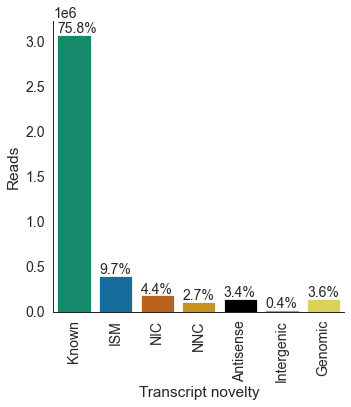

In [8]:
# number / proportion of reads per novelty category
df = pd.read_csv('pgp1_talon_read_annot.tsv', sep='\t')
c_dict, order = get_talon_nov_colors()
opref = 'pgp1'
plot_read_novelty(df, opref, c_dict, order,
                      ylim=None, title=None, 
                      datasets='all')

  transcript_novelty  counts
0          Antisense   34773
1            Genomic   33150
2                ISM   83895
3         Intergenic    8044
4              Known   36205
5                NIC   67933
6                NNC   64771


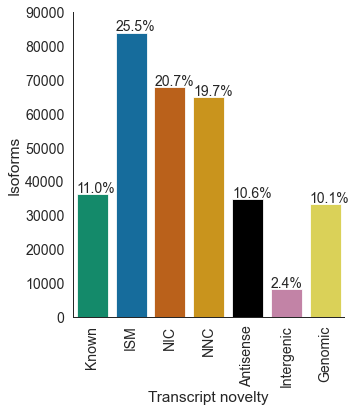

<Figure size 432x288 with 0 Axes>

In [9]:
# unfiltered transcripts per novelty category
df = pd.read_csv('pgp1_talon_read_annot.tsv', sep='\t')
c_dict, order = get_talon_nov_colors()
datasets = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
opref = 'pgp1'
plot_transcript_novelty(df, opref, c_dict, order, \
                    ylim=90000, title='Unfiltered', datasets='all', save_type='pdf')

  transcript_novelty  counts
0          Antisense     414
1                ISM    2058
2         Intergenic      32
3              Known   36205
4                NIC    1108
5                NNC     414


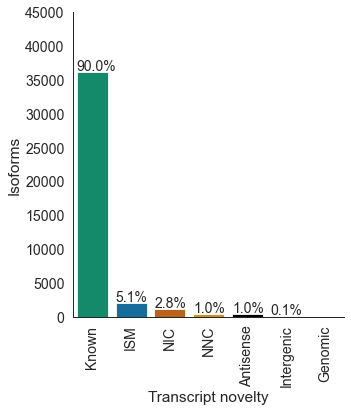

<Figure size 432x288 with 0 Axes>

In [10]:
# filtered transcripts per novelty category
df = pd.read_csv('pgp1_talon_read_annot.tsv', sep='\t')
c_dict, order = get_talon_nov_colors()
datasets = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
opref = 'pgp1'
pass_list = pd.read_csv('pgp1_pass_list.csv', header=None, names=['gene_ID', 'transcript_ID'])
pass_list = pass_list.transcript_ID.unique().tolist()
plot_transcript_novelty(df, opref, c_dict, order, \
                            ylim=45000, title='Filtered',
                            whitelist=pass_list, datasets='all', save_type='pdf')

In [19]:
df = pd.read_csv('pgp1_talon_read_annot.tsv', sep='\t')
datasets = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']
opref = 'pgp1'
pass_list = pd.read_csv('pgp1_pass_list.csv', header=None, names=['gene_ID', 'transcript_ID'])
pass_list = pass_list.transcript_ID.unique().tolist()

print('Number of reads before filtering: {}'.format(len(df.index)))
print('Number of reads after filtering: {}'.format(len(df.loc[df.transcript_ID.isin(pass_list)].index)))

Number of reads before filtering: 4050624
Number of reads after filtering: 3377394


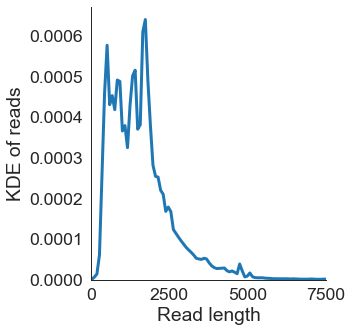

In [11]:
# Distribution of read lengths
df = pd.read_csv('pgp1_talon_read_annot.tsv', sep='\t')
sns.set_context('paper', font_scale=2)    
ax = sns.displot(data=df, x='read_length', kind='kde', linewidth=3)
ax.set(xlabel='Read length', ylabel='KDE of reads',
      title='', xlim=(0,7500),
      xticks=[0, 2500, 5000, 7500])
plt.savefig('{}_read_length_kde.pdf'.format(opref), dpi=300, bbox_inches='tight')

## TSS calling

### Subset TSS reads 

For TSSs, we'll consider Known, prefix ISM, NIC, and NNC reads, as these are more likely to contain putative 5' ends.

In [12]:
annot = 'pgp1_talon_read_annot.tsv'
df = pd.read_csv(annot, sep='\t')
tss_df = df.loc[df.transcript_novelty.isin(['Known', 'NIC', 'NNC', 'ISM'])]
tss_df = tss_df.loc[tss_df.ISM_subtype.isin(['None', 'Prefix', 'Both'])]
tss_reads = tss_df.read_name.tolist()

# tss
fname = 'tss_read_names.txt'
with open(fname, 'w') as ofile:
    for r in tss_reads:
        ofile.write(r+'\n')

This part should be run on the cluster or using bash. It relies on the existence of an intermediate merged bam file that TALON makes when it is running.

The `picard_path` variable refers to wherever [Picard](https://broadinstitute.github.io/picard/) is installed.

```bash
module load samtools
picard_path=/opt/apps/picard-tools/1.87/

in_bam=talon_tmp/merged.bam
out_bam=talon_tmp/merged_rg.bam
tss_reads=tss_read_names.txt
tss_out=tss_reads.bam

# first add the RG header tags for each RG
rg_tags="pgp1_1 pgp1_2 excite_neuron_1 excite_neuron_2 astro_1 astro_2"
samtools view -H $in_bam > header.sam
for tag in $rg_tags
do
    printf '@RG\tID:${tag}\tPL:PacBio\tSM:PGP1\n' >> header.sam
done
samtools reheader header.sam $in_bam > $out_bam

# then limit to the known, prefix ISM, NIC, and NNC reads
java -jar ${picard_path}FilterSamReads.jar \
    I=$out_bam \
    O=$tss_out \
    READ_LIST_FILE=$tss_reads \
    FILTER=includeReadList \
    CREATE_INDEX=true

# index bam file
samtools index $tss_out
```


### Call TSSs

Call transcription start sites using a TSS caller that, roughly, calls peaks on read starts from long read data.

You can download the tool from here: https://github.com/ENCODE-AWG/tss-annotation. Your `tss_dir` should be wherever you install it. 

```bash
tss_dir=~/mortazavi_lab/bin/tss-annotation/long_read/
python ${tss_dir}pacbio_to_tss.py \
    -i tss_reads.bam \
    --window-size=50 \
    --expression-threshold=2 \
    -o unfilt_tss.bed \
    -r \
    -n rev_tss.bw \
    -p fwd_tss.bw
```

Get the read names associated with each TSS peak so that we can associate TSSs with genes
```bash
merged_bam=talon_tmp/merged.bam
python ${tss_dir}tss_reads.py \
    -i $merged.bam \
    -r unfilt_tss.bed \
    -o tss_reads.bed
```

### Filter TSSs based on number of reads and expression within gene

Require TSSs to have at least 2 supporting reads and at least 10 percent of the number of reads that the top-expressed TSS in the gene has.

Additionally save TSS expression in a counts matrix. 

In [14]:
# filter a list of TSSs for each gene
annot = 'pgp1_talon_read_annot.tsv'
tss_reads = 'tss_reads.bed'

df = pd.read_csv(annot, sep='\t')

# remove sirvs and erccs
df = df.loc[~df.chrom.str.contains('SIRV')]
df = df.loc[~df.chrom.str.contains('ERCC')]

ends = pd.read_csv(tss_reads, sep='\t', header=None,
            names=['chrom', 'start', 'end', 'read_name', 'tss_id', 'strand'])

# merge on read name
df = df.merge(ends, how='inner', on='read_name')

# groupby on gene and tss
df = df[['read_name', 'annot_gene_name', 'tss_id']].groupby(['annot_gene_name', 'tss_id']).count()

# filter tsss for those that have >10% of the reads
# for the most highly-expressed tss of the gene
df.reset_index(inplace=True)
df.rename({'read_name':'count'}, axis=1, inplace=True)
temp = df.loc[df.apply(lambda x: x['count'] >= df.loc[df.annot_gene_name==x.annot_gene_name, 'count'].max()*0.1, axis=1)]

temp.loc[temp.annot_gene_name == 'MBP']

# assign each TSS a name, and quantify TSS exp
temp.sort_values(by=['annot_gene_name'], inplace=True)
temp['tss_id_2'] = np.nan
prev_gene = None
for ind, entry in temp.iterrows():
    curr_gene = entry.annot_gene_name
    if curr_gene != prev_gene:
        i = 1
    else:
        i += 1
    prev_gene = curr_gene
    temp.loc[ind, 'tss_id_2'] = '{}_{}'.format(curr_gene, i)
    
# merged called TSSs back in with read annot
df = pd.read_csv(annot, sep='\t')
ends = pd.read_csv(tss_reads, sep='\t', header=None,
            names=['chrom', 'start', 'end', 'read_name', 'tss_id', 'strand'])
ends = ends[['read_name', 'tss_id']]

# dump filtered TSSs to bed 
fname = 'unfilt_tss.bed'
end_regions = pd.read_csv(fname, sep='\t', header=None,
            names=['chrom', 'start', 'end', 'tss_id', 'read_count', 'strand', 
                   'sth1', 'sth2', 'sth3', 'sth4', 'sth5'])
filt_ends = end_regions.merge(temp[['tss_id', 'tss_id_2']], how='inner', on='tss_id')
filt_ends['score'] = 0
filt_ends = filt_ends[['chrom', 'start', 'end', 'tss_id_2', 'score', 'strand']]
fname = 'filt_tss.bed'
filt_ends.to_csv(fname, sep='\t', header=None, index=False)

# merge on read name
df = df.merge(ends, how='inner', on='read_name')
temp = temp[['annot_gene_name', 'tss_id', 'tss_id_2']]
df = df.merge(temp, how='inner', on=['annot_gene_name', 'tss_id'])

# format like talon ab
cols = ['annot_gene_name', 'annot_gene_id', 'dataset', 'tss_id_2']
df = df[cols+['read_name']].groupby(cols).count().reset_index()
df.rename({'read_name':'counts', 'tss_id_2':'tss_id'}, axis=1, inplace=True)
df = df.pivot(index=['annot_gene_name', 'annot_gene_id', 'tss_id'], columns='dataset', values='counts')
df.reset_index(inplace=True)
df = df.rename_axis(None, axis=1)
df.fillna(0, inplace=True)

# i guess sum over genes with the same name smh
df.drop('annot_gene_id', axis=1, inplace=True)
df = df.groupby(['annot_gene_name', 'tss_id']).sum().reset_index()


df.to_csv('pgp1_tss_talon_abundance.tsv', sep='\t', index=False)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

## Swan

In [24]:
annot = 'gencode.v29.annotation.gtf'

# create a config file
df = pd.read_csv('samples.txt', header=None, names=['col'])
df['fname'] = 'pgp1.db'
df['counts_file'] = 'pgp1_talon_abundance.tsv'
df['count_cols'] = df['col']
df['tid_col'] = 'annot_transcript_id'
df['dataset_name'] = df['col']
df['whitelist'] = 'pgp1_pass_list.csv'
df.to_csv('swan_config.tsv', sep='\t', index=False)
    
# initialize SwanGraph
sg = swan.SwanGraph()

# add annotation GTF
sg.add_annotation(annot)

# add datasets and save graph
sg.add_datasets('swan_config.tsv')
sg.save_graph('swan')


Adding dataset annotation to the SwanGraph

Adding dataset pgp1_1 to the SwanGraph

Adding dataset pgp1_2 to the SwanGraph

Adding dataset excite_neuron_1 to the SwanGraph

Adding dataset excite_neuron_2 to the SwanGraph

Adding dataset astro_1 to the SwanGraph

Adding dataset astro_2 to the SwanGraph
Saving graph as swan.p


In [26]:
# detect IR and ES
g_es, t_es, e_es = sg.find_es_genes()
g_ir, t_ir, e_ir = sg.find_ir_genes()

Analyzing 866 intronic edges for ES
Found 237 novel es events in 275 transcripts.
Analyzing 2411 exonic edges for IR
Found 71 novel ir events from 82 transcripts.


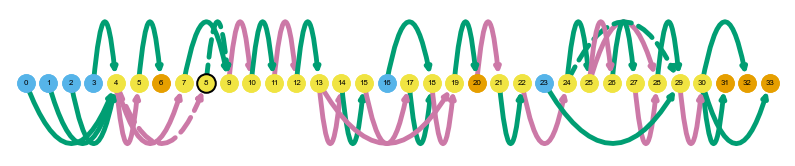

Saving summary graph for ENSG00000031698.12 as figures/SARS_novel_ENSG00000031698.12_summary.png


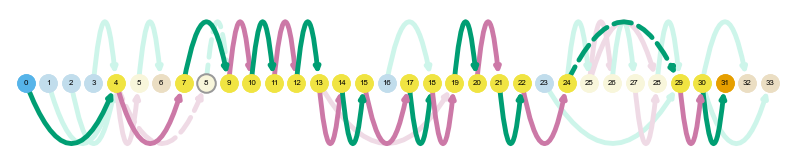

Saving transcript path graph for ENCODEHT000445064 as figures/SARS_novel_ENCODEHT000445064_path.png


In [27]:
# plot gene summary/transcript path graph for a gene with IR (SARS)
sg.plot_graph('SARS', indicate_novel=True, display=True, prefix='figures/SARS')
sg.plot_transcript_path('ENCODEHT000445064', indicate_novel=True, display=True, prefix='figures/SARS')

In [28]:
# plot gene report for the same gene with IR (SARS)
gname = 'SARS'
sg.gen_report(gname, prefix='figures/{}'.format(gname),
    heatmap=True, 
    cmap='viridis', 
    indicate_novel=True,
    novelty=True)
sg.gen_report(gname, prefix='figures/{}'.format(gname),
    heatmap=True, 
    cmap='viridis', 
    browser=True,
    novelty=True)


Plotting transcripts for ENSG00000031698.12
Saving transcript path graph for ENST00000234677.6 as figures/SARS_novel_ENST00000234677.6_path.png
Saving transcript path graph for ENST00000369923.4 as figures/SARS_novel_ENST00000369923.4_path.png
Saving transcript path graph for ENCODEHT000444845 as figures/SARS_novel_ENCODEHT000444845_path.png
Saving transcript path graph for ENST00000482384.1 as figures/SARS_novel_ENST00000482384.1_path.png
Saving transcript path graph for ENCODEHT000445064 as figures/SARS_novel_ENCODEHT000445064_path.png
Saving transcript path graph for ENST00000468588.1 as figures/SARS_novel_ENST00000468588.1_path.png
Generating report for ENSG00000031698.12

Plotting transcripts for ENSG00000031698.12
Saving transcript path graph for ENST00000234677.6 as figures/SARS_browser_ENST00000234677.6_path.png
Saving transcript path graph for ENST00000369923.4 as figures/SARS_browser_ENST00000369923.4_path.png
Saving transcript path graph for ENCODEHT000444845 as figures/SAR

### TSS and isoform switching

Detect statistically-significant instances of isoform or TSS switching from the TALON isoforms or from the called TSSs respectively.

In [12]:
# df: talon abundance file (either tss or transcript)
# cond_map: dictionary of {condition: [dataset1, dataset2]}; how you want to group datasets
# how: whether to make a tss or iso level adata; 'tss' or 'iso'
# pass_list: if 'iso', file of valid transcript IDs that pass filtering
def make_adata(df, cond_map, how='iso', pass_list=None):
    
    # filter talon ab file based on pass list
#     df = pd.read_csv(ab_file, sep='\t')
    if pass_list:
        pass_list = pd.read_csv(pass_list, header=None, names=['gene_id', 'transcript_id'])
        df = df.loc[df.transcript_ID.isin(pass_list.transcript_id.tolist())]

    # obs table
    obs = pd.DataFrame.from_dict(cond_map, orient='index')
    obs.reset_index(inplace=True)
    id_vars = ['index']
    value_vars = obs.columns[1:]
    obs = obs.melt(id_vars=id_vars, value_vars=value_vars)
    obs.drop('variable', axis=1, inplace=True)
    obs.rename({'index':'condition', 'value':'dataset'}, axis=1, inplace=True)

    # var table
    if how=='iso':
        var_cols = ['annot_transcript_name', 'annot_gene_name',\
                    'annot_transcript_id', 'annot_gene_id', \
                    'gene_ID', 'transcript_ID', 'transcript_novelty', \
                    'ISM_subtype']
        var = df[var_cols]
        var.rename({'transcript_ID':'transcript_id', \
                    'gene_ID':'gene_id',\
                    'annot_gene_name': 'gene_name'}, axis=1, inplace=True)
    if how=='tss': 
        var_cols = ['annot_gene_name', 'tss_id']
        var = df[var_cols]
        var.rename({'annot_gene_name': 'gene_name'}, axis=1, inplace=True)
        
    # X table
    df = df.transpose()
    df = df.loc[df.index.isin(obs.dataset.tolist())]
    obs_order = obs['dataset'].reset_index().set_index('dataset')
    df['dataset_num'] = df.index.map(obs_order['index'])
    df.sort_values('dataset_num', inplace=True)
    df.drop('dataset_num', axis=1, inplace=True)
    X = df.to_numpy()

    adata = anndata.AnnData(obs=obs, var=var, X=X) 
    
    return adata

# gene_df: pandas dataframe with expression values in each condition for each TSS in a gene
# conditions: list of str of condition names
# rc: threshold of read count per gene in each condition necessary to test this gene
def test_gene(gene_df, conditions, col, id_col, rc=10):
    
    gene_df = gene_df.pivot(index=col, columns=id_col, values='counts')
    gene_df = gene_df.transpose()
    
    groups = gene_df.columns.tolist()
    gene_df['total_counts'] = gene_df[groups].sum(axis=1)
    gene_df.sort_values(by='total_counts', ascending=False, inplace=True)

    if len(gene_df.index) > 11:
        gene_df.reset_index(inplace=True)

        beep = gene_df.iloc[10:].sum()
        beep[id_col] = 'all_other'
        beep.index.name = None  
        beep = pd.DataFrame(beep).transpose()

        gene_df = gene_df.iloc[:10]
        gene_df = pd.concat([gene_df, beep])  
        
    # limit to just isoforms with > 0 expression in both conditions
    cond1 = conditions[0]
    cond2 = conditions[1]
    gene_df = gene_df.loc[(gene_df[cond1]>0)&(gene_df[cond2]>0)]
    
    # does this gene reach the desired read count threshold?
    for cond in conditions:
        if gene_df[cond].sum() < rc:
            return np.nan, np.nan
    
    # only do the rest if there's nothing left
    if gene_df.empty:
        return np.nan, np.nan
    
    # calculate the percent of each sample each TSS accounts for
    cond_pis = []
    for cond in conditions:
        total_col = '{}_total'.format(cond)
        pi_col = '{}_pi'.format(cond)
        total_count = gene_df[cond].sum()

        cond_pis.append(pi_col)

        gene_df[total_col] = total_count
        gene_df[pi_col] = (gene_df[cond]/gene_df[total_col])*100
        
    # compute isoform-level and gene-level delta pis
    gene_df['dpi'] = gene_df[cond_pis[0]] - gene_df[cond_pis[1]]
    gene_df['abs_dpi'] = gene_df.dpi.abs()
    gene_dpi = gene_df.iloc[:2].abs_dpi.sum()    
    
    # chi squared test 
    chi_table = gene_df[conditions].to_numpy()
    chi2, p, dof, exp = st.chi2_contingency(chi_table)
    
    return p, gene_dpi

def filter_die_results(df, p, dpi):
    df = df.loc[(df.adj_p_val<=p)&(df.dpi>=dpi)]
    return df

# adata: adata with TSS or iso expression 
# conditions: len 2 list of strings of conditions to compare
# col: string, which column the condition labels are in
# how: 'tss' or 'iso'
def get_die(adata, conditions, how='tss', rc=15):
    
    if how == 'tss':
        id_col = 'tss_id'
    elif how == 'iso':
        id_col = 'transcript_id'
    
    # make df that we can groupby
    col = 'condition'
    colnames = adata.var[id_col].tolist()
    rownames = adata.obs.dataset.tolist()    
    raw = adata.X
    df = pd.DataFrame(data=raw, index=rownames, columns=colnames)
    df.reset_index(inplace=True)
    df.rename({'index':'dataset'}, axis=1, inplace=True)
    samp = adata.obs[['dataset', col]]
    df = df.merge(samp, how='left', on='dataset')
    
    # limit to only the samples that we want in this condition
    df[col] = df[col].astype('str')
    df = df.loc[df[col].isin(conditions)]
        
    # groupby sample type and sum over gen
    df.drop('dataset', axis=1, inplace=True)
    df = df.groupby(col).sum().reset_index()
    
    # melty boi
    tss_cols = df.columns.tolist()[1:]
    df = df.melt(id_vars=col, value_vars=tss_cols)
    
    # rename some cols
    df.rename({'variable':id_col,'value':'counts'}, axis=1, inplace=True)
    
    # merge with gene names
    df = df.merge(adata.var, how='left', on=id_col)
    
    # get total number of tss or iso / gene
    bop = df[['gene_name', id_col]].groupby('gene_name').count().reset_index()
    
    # construct tables for each gene and test!
    gene_names = df.gene_name.unique().tolist()
    gene_de_df = pd.DataFrame(index=gene_names, columns=['p_val', 'dpi'], data=[[np.nan for i in range(2)] for j in range(len(gene_names))])
    for gene in gene_names:
        gene_df = df.loc[df.gene_name==gene]
        p, dpi = test_gene(gene_df, conditions, col, id_col, rc=rc)
        gene_de_df.loc[gene, 'p_val'] = p
        gene_de_df.loc[gene, 'dpi'] = dpi
        
    # correct p values 
    gene_de_df.dropna(axis=0, inplace=True)
    p_vals = gene_de_df.p_val.tolist()
    _, adj_p_vals, _, _ = multipletests(p_vals, method='fdr_bh')
    gene_de_df['adj_p_val'] = adj_p_vals
    
    gene_de_df.reset_index(inplace=True)
    
    return gene_de_df

def get_sample_colors():
    c_dict = {'astro_1': '#f6ef7c', 'astro_2': '#eabc68',\
          'excite_neuron_1': '#e4d3cd', 'excite_neuron_2': '#d3a8b2',\
          'pgp1_1': '#bef4ff', 'pgp1_2': '#73a8b2'}
    order = ['pgp1_1', 'pgp1_2', 'astro_1', 'astro_2', 'excite_neuron_1', 'excite_neuron_2']
    return c_dict, order

def make_cond_map(groups, group_names):
    cond_map = dict()
    for group, group_name in zip(groups, group_names):
        cond_map[group] = group_name
    return cond_map

# calculate the normalized average or sum of TSS expression 
# per cell from the TSS anndata object
def calc_exp(adata, groups, group_names, how='tss', cpm=False):
    
    try:
        adata.var.reset_index(inplace=True)
    except:
        pass
    
    if how == 'tss':
        id_col = 'tss_id'
    elif how == 'iso':
        id_col = 'transcript_id'
        
    # conditions map
    cond_map = make_cond_map(groups, group_names)
#     print(cond_map)
    col = 'condition'
    adata.obs.rename({'dataset':'condition'}, axis=1, inplace=True)
#     adata.obs[col] = adata.obs.dataset.map(cond_map)
    
    # make df that we can groupby
    colnames = adata.var[id_col].tolist()
    rownames = adata.obs[col].tolist()    
    raw = adata.X
    gene_names = adata.var.gene_name.tolist()
    df = pd.DataFrame(data=raw, index=rownames, columns=colnames)
    df.reset_index(inplace=True)
    df.rename({'index':col}, axis=1, inplace=True)
    samp = adata.obs[[col]]
    df = df.merge(samp, how='left', on=col)
    
    # limit to only the cells that we want in this condition
    df[col] = df[col].astype('str')
    df = df.loc[df[col].isin(group_names)]
        
    # groupby sample type and sum over gen
#     df.drop(col, axis=1, inplace=True)
    df = df.groupby(col).sum().reset_index()
    
    if cpm:
        # since these values haven't been normalized yet, do that
        # CPM : (counts/total_counts)* 1**6
        # Note : ATAC values were pre-normalized
        df.set_index(col, inplace=True)
        df = df.transpose()
        for c in group_names:
            total_counts = df[c].sum()
            df[c] = (df[c]/total_counts)*(1^6)
        df = df.transpose()
        df.reset_index(inplace=True)
    
    # melty boi
    tss_cols = df.columns.tolist()[1:]
    df = df.melt(id_vars=col, value_vars=tss_cols)
    
    # rename some cols
    df.rename({'variable':id_col,'value':'counts'}, axis=1, inplace=True)
            
    # add gene name
    if how == 'tss':
        temp = adata.var[[id_col, 'gene_name']]
    df = df.merge(temp, how='left', on=id_col)

    return df  

def plot_tss_heatmap(adata, groups, group_names, gname, opref):
    
    # calculate TSS expression per condition
    adata.obs.drop('condition', axis=1, inplace=True)
    tss_df = calc_exp(adata, groups, group_names, how='tss')
    
    # subset by gene and calculate DPI per gene
    tss_df = tss_df.loc[tss_df.gene_name == gname]
    n_tss = len(tss_df.tss_id.unique())
    tss_df.drop(['gene_name'], axis=1, inplace=True)
    tss_df = tss_df.pivot(index='tss_id', columns='condition', values='counts')
    tss_df = tss_df.div(tss_df.sum(axis=0), axis=1)
    
    # get categorical colormap
    tss_df = tss_df[groups]
    mini_obs, cat_cmap = get_cat_cmap(groups)
    
    # plot the figure
    sns.set(rc={'figure.figsize':(12,7)})
    sns.set_context('paper', font_scale=1.5)
    fig = plt.figure()
    

    # complicated subplot stuff
    tss_ax = plt.subplot2grid((n_tss+1,1), loc=(0,0), rowspan=n_tss)

    # fig, axes = plt.subplots(nrows=4)
    fig.subplots_adjust(hspace=0.00)
    fig.subplots_adjust(wspace=0.05)

    # plot tss only plot
    sns.heatmap(tss_df, cmap='magma', ax=tss_ax, cbar=False)
    tss_ax.set_yticklabels(tss_ax.get_yticklabels(), rotation=0)
    tss_ax.set_ylabel('')
    tss_ax.set_xlabel('')

    # plot sample labels
    tss_colorbar_ax = fig.add_subplot((n_tss+1)*2,1,((n_tss+1)*2)-1)
    sns.heatmap(mini_obs, cmap=cat_cmap,
                ax=tss_colorbar_ax, cbar=False)
    tss_colorbar_ax.set_ylabel('')
    tss_colorbar_ax.set_xlabel('')
    tss_colorbar_ax.tick_params(left=False, labelleft=False, rotation=0)
    tss_colorbar_ax.tick_params(right=False, labelright=False, rotation=0)
    tss_colorbar_ax.set_xticklabels('')

    # plot colorbars
    tss_colorbar_ax = fig.add_subplot((n_tss+1)*5,1,((n_tss+1)*5)-1)
    cmap = plt.get_cmap('magma')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = mpl.colorbar.ColorbarBase(tss_colorbar_ax, cmap=cmap,
                                  norm=norm, orientation='horizontal')
    cb.set_label('Proportion TSS usage')
    
    fname = '{}_{}_heatmap.pdf'.format(opref, gname)
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    
def get_cat_cmap(sample_order):
    
    # get condition and cluster colors
    samp_cdict, _ = get_sample_colors()
    samples = sample_order
    data = np.transpose([samples])
    df = pd.DataFrame(data=data, 
                      columns=['sample'])

    # assign arbitrary numbers to each category (cluster, condition)
    cats = samples
    cat_dict = dict([(cat, i) for i, cat in enumerate(cats)])
    df['sample'] = df['sample'].map(cat_dict)
    df = df.transpose()
    
    colors = [samp_cdict[cat] for cat in cats]
    cat_cmap = ListedColormap(colors)
    return df, cat_cmap

### TSS switching

In [ ]:
ab_file = 'pgp1_tss_talon_abundance.tsv'
cond_map = {'Astrocytes': ['astro_1', 'astro_2'], \
            'Excitatory neurons': ['excite_neuron_1', 'excite_neuron_2'], \
            'PGP1': ['pgp1_1', 'pgp1_2']}

df = pd.read_csv(ab_file, sep='\t')a
adata = make_adata(df, cond_map, how='tss')

fname = 'tss.h5ad'
adata.write(fname)

# do one test for each pair of conditions
tested = []
conditions = ['Astrocytes', 'Excitatory neurons', 'PGP1']
how = 'tss'
p = 0.05 # adjusted p-value threshold
dpi = 10 # change in percent usage (dpi) threshold
for c1 in conditions:
    for c2 in conditions: 
        if (c1, c2) in tested or c1 == c2 or (c2, c1) in tested:
            continue
        else:
            tested.append((c1,c2))
        df = get_die(adata, [c1, c2], how=how, rc=10)
        
        # all results
        fname = '{}_{}_{}_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t', index=False)
        
        # significant results
        df = filter_die_results(df, p, dpi)
        fname = '{}_{}_{}_sig_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t')

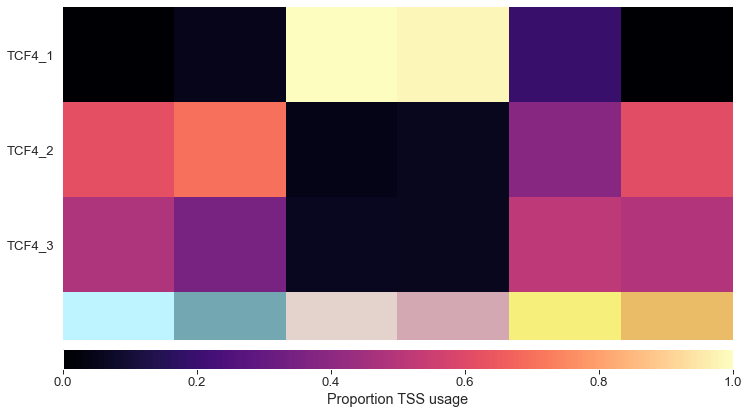

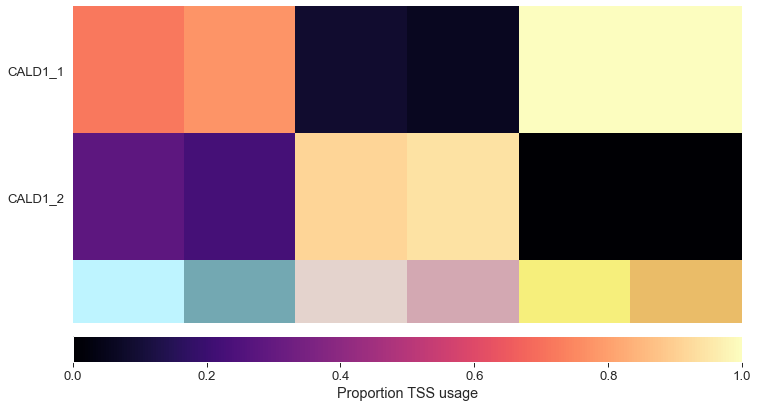

In [14]:
# visualize some TSS switches that were called
adata = sc.read('tss.h5ad')
groups = ['pgp1_1', 'pgp1_2', 'excite_neuron_1', 'excite_neuron_2', 'astro_1', 'astro_2']

tss_df = plot_tss_heatmap(adata, groups, groups, 'TCF4', 'figures/tss')

adata = sc.read('tss.h5ad')
tss_df = plot_tss_heatmap(adata, groups, groups, 'CALD1', 'figures/tss')

### Isoform switching

In [5]:
ab_file = 'pgp1_tss_talon_abundance.tsv'
pass_list = 'pgp1_pass_list.csv'
cond_map = {'Astrocytes': ['astro_1', 'astro_2'], \
            'Excitatory neurons': ['excite_neuron_1', 'excite_neuron_2'], \
            'PGP1': ['pgp1_1', 'pgp1_2']}

df = pd.read_csv(ab_file, sep='\t')
adata = make_adata(df, cond_map, how='tss')

fname = 'tss.h5ad'
adata.write(fname)

# do one test for each pair of conditions
tested = []
conditions = ['Astrocytes', 'Excitatory neurons', 'PGP1']
how = 'tss'
p = 0.05 # adjusted p-value threshold
dpi = 10 # change in percent usage (dpi) threshold
for c1 in conditions:
    for c2 in conditions: 
        if (c1, c2) in tested or c1 == c2 or (c2, c1) in tested:
            continue
        else:
            tested.append((c1,c2))
            print('Testing {} vs. {}'.format(c1, c2))
        df = get_die(adata, [c1, c2], how=how, rc=10)
        
        # all results
        fname = '{}_{}_{}_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t', index=False)
        
        # significant results
        df = filter_die_results(df, p, dpi)
        fname = '{}_{}_{}_sig_die.tsv'.format(c1, c2, how)
        df.to_csv(fname, sep='\t')

In [16]:
# use Swan to visualize some isoform switches
sg = swan.SwanGraph('swan.p')
gnames = ['TPD52L2', 'AP2M1', 'SRSF3', 'SRSF7']
for gname in gnames: 
    # dpi swangraph
    sg.gen_report(gname, prefix='figures/{}_dpi'.format(gname),
        heatmap=True, 
        dpi=True, 
        cmap='magma', 
        indicate_novel=True,
        novelty=True)

    # tpm swangraph
    sg.gen_report(gname, prefix='figures/{}'.format(gname),
        heatmap=True, 
        cmap='viridis', 
        indicate_novel=True,
        novelty=True)
    
    # dpi browser
    sg.gen_report(gname, prefix='figures/{}_dpi'.format(gname),
        heatmap=True, 
        dpi=True, 
        cmap='magma', 
        browser=True,
        novelty=True)

    # tpm browser
    sg.gen_report(gname, prefix='figures/{}'.format(gname),
        heatmap=True, 
        cmap='viridis', 
        browser=True,
        novelty=True)

Graph from swan.p loaded

Plotting transcripts for ENSG00000101150.17
Saving transcript path graph for ENST00000346249.8 as figures/TPD52L2_dpi_novel_ENST00000346249.8_path.png
Saving transcript path graph for ENST00000348257.9 as figures/TPD52L2_dpi_novel_ENST00000348257.9_path.png
Saving transcript path graph for ENST00000358548.4 as figures/TPD52L2_dpi_novel_ENST00000358548.4_path.png
Saving transcript path graph for ENST00000352482.8 as figures/TPD52L2_dpi_novel_ENST00000352482.8_path.png
Saving transcript path graph for ENST00000217121.9 as figures/TPD52L2_dpi_novel_ENST00000217121.9_path.png
Saving transcript path graph for ENST00000351424.8 as figures/TPD52L2_dpi_novel_ENST00000351424.8_path.png
Saving transcript path graph for ENST00000474176.2 as figures/TPD52L2_dpi_novel_ENST00000474176.2_path.png
Generating report for ENSG00000101150.17

Plotting transcripts for ENSG00000101150.17
Saving transcript path graph for ENST00000346249.8 as figures/TPD52L2_novel_ENST00000346249.8_p

## Visualizing reads and TSSs on the genome browser

### Hub file 
Use [this link](http://crick.bio.uci.edu/freese/210413_pgp1_hub/hub/hub.txt) to view my tracks on your genome browser session

### Convert TSS bed to bigBed
Convert the bed file of filtered TSSs that can be displayed on the genome browser.

To download the bedToBigBed software, use the conda installation instructions here: https://anaconda.org/bioconda/ucsc-bedtobigbed

```bash
bed='filt_tss.bed'
chrom_sizes='hg38.chrom.sizes'
bedToBigBed \
    $bed \
    $chrom_sizes \
    filt_tss.bb
```

### Creating and hosting the track hub

This part requires you have use of a server with public-facing access [example](http://crick.bio.uci.edu/freese/). The old HPC had one which was really useful (the link used to look like https://hpc.oit.uci.edu/~freese), but there is none for HPC3 and they are not planning on releasing one (I asked HPC support about this). Therefore I'm not sure how useful this will be for those that do not have their own lab server.

In [25]:
c_dict, order = get_sample_colors()
sample_file = 'samples.txt' # sample file with one sample per line
genome = 'hg38' # genome 
hub_name = 'pgp1' # name of hub
tss = 'filt_tss.bb' # tss file
email = 'freese@uci.edu' # email of hub creator

# URL location of hub
url = 'http://crick.bio.uci.edu/freese/210413_pgp1_hub/'

# ssh location of hub (used to copy)
# if you do not want to automatically move files to server then don't provide
# an argument to scp_location in the `make_hub` call. 
scp_location = 'freese@crick.bio.uci.edu:~/pub/210413_pgp1_hub/'

make_hub(url, c_dict, samples, genome, hub_name, email, scp_location=None)

In [24]:
def make_bam_hub_entry(df, c_dict, ofile):
    with open(ofile, 'w') as o:
        for ind, e in df.iterrows():
            c = c_dict[e['sample']]
            c = c.lstrip('#')
            c = tuple(int(c[i:i+2], 16) for i in (0, 2, 4))

            s = 'track {}_reads\n'.format(e['sample'])
            s += 'bigDataUrl {}\n'.format(e.url)
            s += 'shortLabel {}_reads\n'.format(e['sample'])
            s += 'longLabel {}_reads\n'.format(e['sample'])
            s += 'type bam\n'
            s += 'visibility squish\n'
            s += 'bamColorMode off\n'
            s += 'color {},{},{}\n\n'.format(c[0],c[1],c[2])
            o.write(s)


def make_tss_hub_entry(tss, url, ofile):
    with open(ofile, 'a') as o:
        s = 'track tss\n'
        s += 'type bigBed 6\n'
        s += 'bigDataUrl {}{}\n'.format(url, tss)
        s += 'shortLabel tss \n'
        s += 'longLabel tss\n'
        s += 'visibility dense\n'
        o.write(s)
            
# this function probably won't be useful for anyone
# relies on talon_tmp/ bam files 
def make_hub(url, c_dict, samples, genome, hub_name, email, scp_location=None): 
    
    genomefile = 'hub/genomes.txt'
    hubfile = 'hub/hub.txt'
    hubfile_relative = 'hub.txt'
    trackdb = 'hub/{}/trackDb.txt'.format(genome)
    relative_trackdb = '{}/trackDb.txt'.format(genome)
    relative_genome = 'genomes.txt'
    try:
        os.makedirs(os.path.dirname(trackdb))
    except:
        pass
    df = pd.read_csv(sample, header=None, names=['sample'])
                     
    df['url'] = df.apply(lambda x: url+x['sample']+'.bam', axis=1)
    df['local_loc'] = df.apply(lambda x: 'talon_tmp/'+x['sample']+'.bam', axis=1)

    for ind, entry in df.iterrows():
        cmd = 'samtools index {}'.format(entry.local_loc)
        print(cmd)
        cmd = shlex.split(cmd)
        result = subprocess.run(cmd)  

        if scp_location:
            cmd = 'scp {} {}'.format(entry.local_loc, scp_location)
            cmd = shlex.split(cmd)
            print(cmd)
            result = subprocess.run(cmd)

            cmd = 'scp {}.bai {}'.format(entry.local_loc, scp_location)
            cmd = shlex.split(cmd)
            print(cmd)
            result = subprocess.run(cmd)

    make_bam_hub_entry(df, c_dict, trackdb)
    make_tss_hub_entry(tss, url, trackdb)

    with open(genomefile, 'w') as o:
        s = 'genome {}\n'.format(genome)
        s += 'trackDb {}\n'.format(relative_trackdb)
        o.write(s)

    with open(hubfile, 'w') as o:
        s = 'hub {}\n'.format(hub_name)
        s += 'shortLabel {}\n'.format(hub_name)
        s += 'longLabel {}\n'.format(hub_name)
        s += 'genomesFile {}\n'.format(relative_genome)
        s += 'email {}\n'.format(email)
        o.write(s)

    if scp_location:
        cmd = 'scp -r hub/ {}'.format(scp_location)
        cmd = shlex.split(cmd)
        result = subprocess.run(cmd)